<a href="https://colab.research.google.com/github/ben-samir/fenics_sandbox/blob/main/cylinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fenics for NS computations
**Author**: Samir Beneddine

**Acknowledgment**: Adapted from the scripts of J. Moulin

## Setup of the environment
This notebook is linked to a github repository. You will need to generate a GitHub token in order to provide access to the repository to Colab. The animation below shows how to generate the token from github. When executing the first code cell below, you will be asked to type this token.

**Important**: this token will be asked everytime you run this notebook, so keep it in a convenient place and do not lose it or you will need to generate a new one.

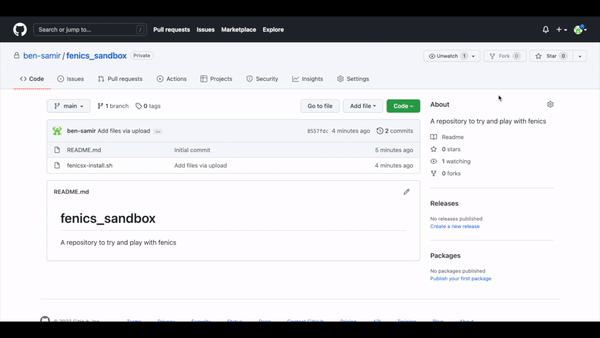

In [2]:
# The installation of Fenics last approx 1 min
# First we check if we are on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# if on Colab, we load the data needed
if IN_COLAB:
    # Note: the specific versions of dolfinx and multiphenicsx are hard-coded in
    # scripts on the repository in order to avoid API change issues
    import os
    from getpass import getpass
    import urllib

    # the private repo that I created on GitHub
    repo_name = "ben-samir/fenics_sandbox"
    directory = "/tmp/fenics_sandbox/"
    
    # clone repo 
    !rm -r $directory # force remove the directory if exists
    print("I need access to several files from the private GitHub repo {:s}".format(repo_name))
    user_pat = getpass('User\'s GitHub Personal Access Token: ')
    url = 'https://{:s}@github.com/{:s} {:s}'.format(user_pat, repo_name, directory)
    del user_pat
    !git clone $url
    
    !bash $directory"fenicsx-install.sh" # get dolfinx
    # !pip install git+https://github.com/multiphenics/multiphenicsx@d3a4b004514de7357cfe02c7ed23caec133aba7d#egg=multiphenicsx[tutorials] # get multiphenicsx (with tutorials extra requirements)

    import sys
    sys.path.insert(1, directory)

    !pip install -q piglet pyvirtualdisplay
    !pip install -q pyvista
    !apt-get -qq install xvfb
    
    from google.colab import output
    output.enable_custom_widget_manager()
else: # if this is not executed on Colab
    directory = "./"

I need access to several files from the private GitHub repo ben-samir/fenics_sandbox
User's GitHub Personal Access Token: ··········
Cloning into '/tmp/fenics_sandbox'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 112 (delta 53), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (112/112), 3.57 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (53/53), done.
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]


## Studied case: flow past a cylinder
This notebook shows how to compute a steady solution for a laminar flow past a cylinder

First some imports

In [3]:
import ufl
import dolfinx
import petsc4py
import numpy as np
import numpy.typing
import typing
import tqdm.notebook
from dolfinx.io import XDMFFile
from mpi4py import MPI
import pyvista
from dolfinx.plot import create_vtk_mesh

Then we load the mesh. The mesh is a xdmf file read from the github repository. It contains tags for each boundary (edge) and for the fluid domain (surface). 

The repository contains two scripts to generate it and convert it to fenicsx-compatible format.

**Warning:** the mesh has been generated for a demonstration purpose. Its adequate spatial resolution has not been checked.


In [4]:
# Read the mesh and retrieve cells and facets tags from XDMF
mesh_path = directory + "/mesh/cylinder.xdmf"

with XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as xdmf:
    mesh = xdmf.read_mesh(name="mesh")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim-1)

with XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Facet tags")

# Tags definitions
fluid_marker = 1
inlet_marker = 2
outlet_marker = 3
side_marker = 4
obstacle_marker = 5



Then we write the variational form of the problem (Steady incompressible Navier-Stokes equations).


In [5]:
V_element = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
Q_element = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

"""Run standard FEniCSx formulation using a mixed function space."""
# Function spaces
W_element = ufl.MixedElement(V_element, Q_element)
W = dolfinx.fem.FunctionSpace(mesh, W_element)

# Test and trial functions
vq = ufl.TestFunction(W)
(v, q) = ufl.split(vq)
dup = ufl.TrialFunction(W)
up = dolfinx.fem.Function(W) # since the problem is nonlinear, a "Function" js created to store solution
(u, p) = ufl.split(up)

# Variational forms (Be careful with the use of grad() or nabla_grad(), one is
# dui/dxj, the other duj/dxi, see documentation)
Re = 40.
nu = 1. / Re
F = (nu * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
      + ufl.inner(ufl.grad(u) * u, v) * ufl.dx
      - ufl.inner(p, ufl.div(v)) * ufl.dx
      + ufl.inner(ufl.div(u), q) * ufl.dx)

# Linearization of the varf
J = ufl.derivative(F, up, dup)

We then set-up the boundary conditions

In [6]:
# Boundary conditions
def u_in_eval(x: np.typing.NDArray[np.float64]) -> np.typing.NDArray[petsc4py.PETSc.ScalarType]:
    """Return the flat velocity profile at the inlet."""
    values = np.zeros((2, x.shape[1]))
    values[0, :] = 1.0
    return values

def u_wall_eval(x: np.typing.NDArray[np.float64]) -> np.typing.NDArray[petsc4py.PETSc.ScalarType]:
    """Return the zero velocity at the wall."""
    return np.zeros((2, x.shape[1]))

def p_out_eval(x: np.typing.NDArray[np.float64]) -> np.typing.NDArray[petsc4py.PETSc.ScalarType]:
    """Return the zero velocity at the wall."""
    return np.zeros((x.shape[1]))

# we use function to define the values for u_in, u_wall and p_out
u_in = dolfinx.fem.Function(W.sub(0).collapse()[0])
u_in.interpolate(u_in_eval)

u_wall = dolfinx.fem.Function(W.sub(0).collapse()[0])
u_wall.interpolate(u_wall_eval)

p_out = dolfinx.fem.Function(W.sub(1).collapse()[0])
p_out.interpolate(p_out_eval)

# then for each tagged edge, we search for the associated d.o.f. with 
# locate_dofs_topological, then impose the dirichlet bc using dirichletbc

# walls
wall_facets = ft.indices[ft.values == obstacle_marker]
bdofs_wall = dolfinx.fem.locate_dofs_topological(
    (W.sub(0), W.sub(0).collapse()[0]), mesh.topology.dim - 1, wall_facets)
wall_bc = dolfinx.fem.dirichletbc(u_wall, bdofs_wall, W.sub(0))

# sides
sides_facets = ft.indices[ft.values == side_marker]
bdofs_side = dolfinx.fem.locate_dofs_topological(
    (W.sub(0), W.sub(0).collapse()[0]), mesh.topology.dim - 1, sides_facets)
sides_bc = dolfinx.fem.dirichletbc(u_in, bdofs_side, W.sub(0))

# inlet
inlet_facets = ft.indices[ft.values == inlet_marker]
bdofs_inlet = dolfinx.fem.locate_dofs_topological(
    (W.sub(0), W.sub(0).collapse()[0]), mesh.topology.dim - 1, inlet_facets)
inlet_bc = dolfinx.fem.dirichletbc(u_in, bdofs_inlet, W.sub(0))

# outlet
outlet_facets = ft.indices[ft.values == outlet_marker]
bdofs_outlet = dolfinx.fem.locate_dofs_topological(
    (W.sub(1), W.sub(1).collapse()[0]), mesh.topology.dim - 1, outlet_facets)
outlet_bc = dolfinx.fem.dirichletbc(p_out, bdofs_outlet, W.sub(1))

# list of all BCs
bc = [inlet_bc, outlet_bc, sides_bc,  wall_bc]

Finally we can solve the problem using the built-in Newton solver from petsc

In [7]:
# Class for interfacing with SNES, the Navier-Stokes tool from petsc
class NavierStokesProblem(object):
    """Define a nonlinear problem, interfacing with SNES."""
    def __init__(
        self, F: ufl.Form, J: ufl.Form, solution: dolfinx.fem.Function,
        bcs: typing.List[dolfinx.fem.DirichletBCMetaClass], P: typing.Optional[ufl.Form] = None
    ) -> None:
        self._F = dolfinx.fem.form(F)
        self._J = dolfinx.fem.form(J)
        self._obj_vec = dolfinx.fem.petsc.create_vector(self._F)
        self._solution = solution
        self._bcs = bcs
        self._P = P

    def create_snes_solution(self) -> petsc4py.PETSc.Vec:
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: petsc4py.PETSc.Vec) -> None:
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=petsc4py.PETSc.InsertMode.INSERT, mode=petsc4py.PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x

    def obj(self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec) -> np.float64:
        """Compute the norm of the residual."""
        self.F(snes, x, self._obj_vec)
        return self._obj_vec.norm()
        
    def F(self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec, F_vec: petsc4py.PETSc.Vec) -> None:
        """Assemble the residual."""
        self.update_solution(x)
        with F_vec.localForm() as F_vec_local:
            F_vec_local.set(0.0)
        dolfinx.fem.petsc.assemble_vector(F_vec, self._F)
        dolfinx.fem.apply_lifting(F_vec, [self._J], [self._bcs], x0=[x], scale=-1.0)
        F_vec.ghostUpdate(addv=petsc4py.PETSc.InsertMode.ADD, mode=petsc4py.PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(F_vec, self._bcs, x, -1.0)
        # see for instance https://fenicsproject.discourse.group/t/how-to-set-bcs-for-petsc-matrices-and-petsc-vectors-in-dolfinx/4135
        # for the BC treatment

    def J(
        self, snes: petsc4py.PETSc.SNES, x: petsc4py.PETSc.Vec, J_mat: petsc4py.PETSc.Mat,
        P_mat: petsc4py.PETSc.Mat
    ) -> None:
        """Assemble the jacobian."""
        J_mat.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(J_mat, self._J, self._bcs, diagonal=1.0)
        J_mat.assemble()
        if self._P is not None:
            P_mat.zeroEntries()
            dolfinx.fem.petsc.assemble_matrix(P_mat, self._P, self._bcs, diagonal=1.0)
            P_mat.assemble()

# Create problem
problem = NavierStokesProblem(F, J, up, bc)
F_vec = dolfinx.fem.petsc.create_vector(problem._F)
J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

# Solve
snes = petsc4py.PETSc.SNES().create(mesh.comm)
snes.setTolerances(max_it=20)
snes.getKSP().setType("preonly")
snes.getKSP().getPC().setType("lu")
snes.getKSP().getPC().setFactorSolverType("mumps")
snes.setObjective(problem.obj)
snes.setFunction(problem.F, F_vec)
snes.setJacobian(problem.J, J=J_mat, P=None)
snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.2e"%(it,residual)))
up_copy = problem.create_snes_solution()
snes.solve(None, up_copy)
problem.update_solution(up_copy)  # TODO can this be safely removed?

iteration 00: residual = 2.75e+01
iteration 01: residual = 6.72e-03
iteration 02: residual = 4.60e-04
iteration 03: residual = 2.68e-06
iteration 04: residual = 5.37e-11


The solution is converged, we can now plot it 🙂


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.



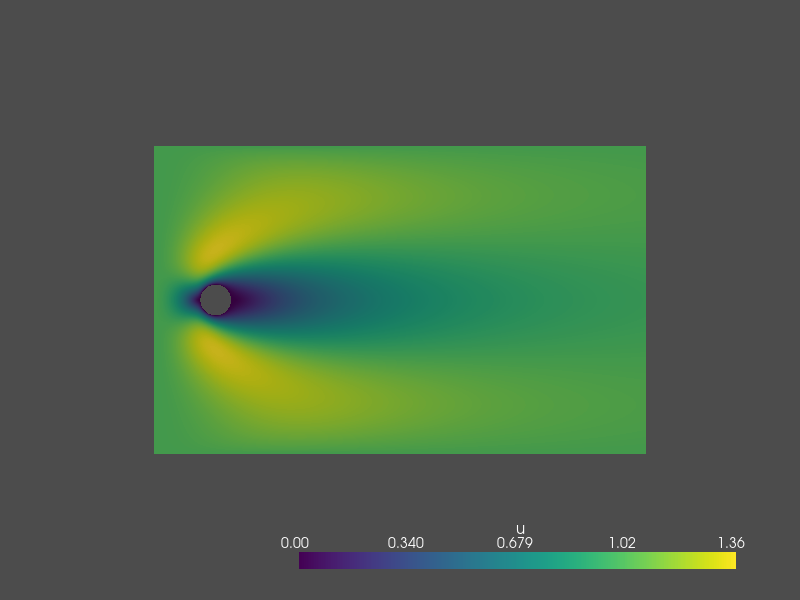

In [13]:
# note that using pyvista on colab is tricky and requires sone extra lines of code\
# otherwise colab kernel crashes and reset

from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

(u_f, p_f) = (up.sub(0).collapse(), up.sub(1).collapse())

pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(u_f.function_space)
values = u_f.x.array.reshape(coordinates.shape[0], u_f.function_space.dofmap.index_map_bs)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
grid.point_data["u"] = values

plotter = pyvista.Plotter(notebook=True, window_size=(800,600))
plotter.add_mesh(grid)
plotter.camera_position = 'xy'
plotter.show()


# pyvista.start_xvfb()
# plotter = pyvista.PlotterITK()
# plotter.add_mesh(grid)
# plotter.set_position([0,0,1], reset=False)
# plotter.show(title="test")
